In [1]:
from os import listdir
import cv2
from PIL import Image
import random
import numpy as np


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import torch.nn.functional as F
from torchvision import models, transforms, datasets

In [4]:
# Set device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### CONFIG

In [5]:
# Hyperparameters.
learning_rate = 1e-3
batch_size = 128
num_epochs = 200
train_split = 0.7
image_size = (224, 224)
num_workers = 2
TRAIN = True

In [6]:
# Load data.
datasets_info = {
    "WLASL": {"name": "WLASL_frames_100", "path": "WLASL/frames_100"},
    "animals": {"name": "animals_simple", "path": "animals/all"},
}


dataset_name = "WLASL"
data_dir = f"../../data/{datasets_info[dataset_name]['path']}"


### Input labels with images

In [7]:
input_labels = listdir(data_dir)
input_labels[:5]

['accident', 'africa', 'all', 'apple', 'basketball']

In [8]:
def show_image(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.show()
  
def imshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

mother


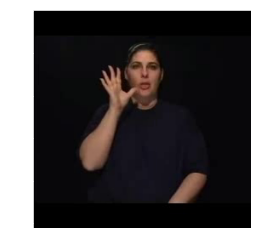

In [9]:
label = input_labels[random.randint(0, len(input_labels) - 1)]
label_images = listdir(data_dir + "/" + label)
label_images

print(label)

image = cv2.imread(data_dir + "/" + label + "/" + label_images[0])
show_image(image)


### Create dataloader for pytorch

In [10]:
from torch.utils.data.sampler import SubsetRandomSampler


In [11]:
transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


### Using random_split

In [12]:
def load_random_split_dataset(data_dir, train_split=0.7, batch_size=32):
    dataset = datasets.ImageFolder(data_dir, transform=transform)

    classes = dataset.classes
    dataset_len = len(dataset)

    train_split = int(train_split * dataset_len)
    tets_split = dataset_len - train_split
    train_set, test_set = random_split(dataset, [train_split, tets_split])

    train_loader = DataLoader(
        dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    test_loader = DataLoader(
        dataset=test_set, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    return train_loader, test_loader, classes


### Solution to unbalanced labels 1: Random dataset split to solve unbalanced labels

In [13]:
def load_split_dataset(data_dir, train_split=0.7, batch_size=32):
    dataset = datasets.ImageFolder(data_dir, transform=transform)

    classes = dataset.classes
    dataset_len = len(dataset)

    ran_ind = torch.randperm(dataset_len)  # 1. random
    # seq_ind = list(range(dataset_len))  # 2. sequential

    indices = ran_ind
    split = int(np.floor(train_split * dataset_len))
    train_indices, test_indices = indices[:split], indices[split:]

    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(
        dataset,
        sampler=train_sampler,
        batch_size=batch_size,
        num_workers=num_workers,
    )
    test_loader = DataLoader(
        dataset,
        sampler=test_sampler,
        batch_size=batch_size,
        num_workers=num_workers,
    )

    return train_loader, test_loader, classes


### Uso del dataset

In [14]:
train_loader, test_loader, classes = load_split_dataset(
    data_dir,
    train_split=train_split,
    batch_size=batch_size,
)

num_classes = len(classes)

print(len(train_loader))
print(len(test_loader))
print(train_loader.batch_size)


34
15
128


### Check how many images are in each loader for every label

In [15]:
def check_balance_status(loader):
    class_count = {}

    for _, targets in loader:
        for target in targets:
            label = classes[target]
            if label not in class_count:
                class_count[label] = 0
            class_count[label] += 1

    return sorted(class_count.items())


train_class_count = check_balance_status(train_loader)
test_class_count = check_balance_status(test_loader)

pc_mean = 0

for tr, te in zip(train_class_count, test_class_count):
    tr_pc = tr[1] / (tr[1] + te[1]) * 100
    pc_mean += tr_pc
    print(f"{tr[0]} - TR: {tr[1]} TS: {te[1]} - PC-TR: {tr_pc:.2f}%")
    
pc_mean /= len(train_class_count)
print(f"Mean PC-TR: {pc_mean:.2f}%")


accident - TR: 40 TS: 17 - PC-TR: 70.18%
africa - TR: 33 TS: 21 - PC-TR: 61.11%
all - TR: 45 TS: 18 - PC-TR: 71.43%
apple - TR: 41 TS: 16 - PC-TR: 71.93%
basketball - TR: 42 TS: 12 - PC-TR: 77.78%
bed - TR: 42 TS: 18 - PC-TR: 70.00%
before - TR: 53 TS: 25 - PC-TR: 67.95%
bird - TR: 43 TS: 14 - PC-TR: 75.44%
birthday - TR: 36 TS: 18 - PC-TR: 66.67%
black - TR: 37 TS: 26 - PC-TR: 58.73%
blue - TR: 41 TS: 19 - PC-TR: 68.33%
book - TR: 81 TS: 39 - PC-TR: 67.50%
bowling - TR: 42 TS: 18 - PC-TR: 70.00%
brown - TR: 40 TS: 14 - PC-TR: 74.07%
but - TR: 38 TS: 16 - PC-TR: 70.37%
can - TR: 40 TS: 20 - PC-TR: 66.67%
candy - TR: 44 TS: 28 - PC-TR: 61.11%
chair - TR: 47 TS: 31 - PC-TR: 60.26%
change - TR: 39 TS: 18 - PC-TR: 68.42%
cheat - TR: 43 TS: 11 - PC-TR: 79.63%
city - TR: 43 TS: 11 - PC-TR: 79.63%
clothes - TR: 50 TS: 25 - PC-TR: 66.67%
color - TR: 49 TS: 8 - PC-TR: 85.96%
computer - TR: 67 TS: 23 - PC-TR: 74.44%
cook - TR: 38 TS: 16 - PC-TR: 70.37%
cool - TR: 39 TS: 24 - PC-TR: 61.90%
corn -

### Load pretrained resnet model

In [16]:
# Load pretrain model & modify it.
# model = models.resnet18(pretrained=True)
model = models.resnet50(pretrained=True)

In [17]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, num_classes),
    nn.LogSoftmax(dim=1),
)


In [18]:
# Loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Freeze model and train only last layer

In [19]:
def plot_costs(costs):
    # Plot cost.
    plt.plot(costs)
    plt.ylabel("Cost")
    plt.xlabel("Epoch")
    plt.show()


Cost at epoch 1 is 4.61974
Cost at epoch 2 is 4.47832
Cost at epoch 3 is 4.33762
Cost at epoch 4 is 4.16120
Cost at epoch 5 is 4.00002
Cost at epoch 6 is 3.84181
Cost at epoch 7 is 3.69202
Cost at epoch 8 is 3.58832
Cost at epoch 9 is 3.44422
Cost at epoch 10 is 3.34468
Cost at epoch 11 is 3.23763
Cost at epoch 12 is 3.16922
Cost at epoch 13 is 3.06312
Cost at epoch 14 is 2.97131
Cost at epoch 15 is 2.92815
Cost at epoch 16 is 2.84795
Cost at epoch 17 is 2.74031
Cost at epoch 18 is 2.69781
Cost at epoch 19 is 2.63769
Cost at epoch 20 is 2.62280
Cost at epoch 21 is 2.52229
Cost at epoch 22 is 2.47587
Cost at epoch 23 is 2.44523
Cost at epoch 24 is 2.38474
Cost at epoch 25 is 2.28951
Cost at epoch 26 is 2.27283
Cost at epoch 27 is 2.26281
Cost at epoch 28 is 2.22225
Cost at epoch 29 is 2.16530
Cost at epoch 30 is 2.16160
Cost at epoch 31 is 2.10646
Cost at epoch 32 is 2.06275
Cost at epoch 33 is 2.04670
Cost at epoch 34 is 1.99957
Cost at epoch 35 is 1.96559
Cost at epoch 36 is 1.90843
C

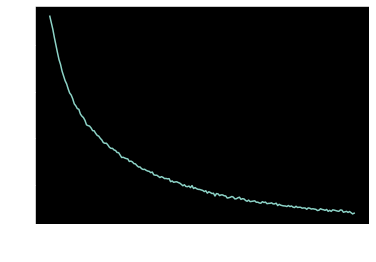

In [20]:
def train():
    # Train network.
    costs = []

    for epoch in range(num_epochs):
        losses = []

        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)

            # forward.
            scores = model(data)
            loss = criterion(scores, targets)
            losses.append(loss.item())

            # backward.
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step.
            optimizer.step()

        cost = sum(losses) / len(losses)
        costs.append(cost)
        print(f"Cost at epoch {epoch + 1} is {cost:.5f}")

    return costs

if TRAIN:
    costs = train()
    plot_costs(costs)


### Save model

In [21]:
model_name = datasets_info[dataset_name]["name"]
model_path = f"../../models/resnet_{model_name}.pth"

In [22]:
# Export model.
torch.save(model, model_path)


### Load saved model

In [23]:
# Import model for acc test.
model = torch.load(model_path)
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Try to quantize model

In [24]:
cpu_model = model.to("cpu")
quantized_model = torch.quantization.quantize_dynamic(
    cpu_model,
    {nn.Linear, nn.ReLU, nn.Dropout, nn.Linear, nn.LogSoftmax},
    dtype=torch.qint8,
)
quantized_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Save quantized model

In [25]:
# Export model.
model_path = f"../../models/resnet_{model_name}_quantized.pth"
torch.save(quantized_model, model_path)

### Test net

In [26]:
# Check accuracy on training & test to see how good our model predicts.
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0

    with torch.no_grad():
        for i, (x, y) in enumerate(loader):

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

            # Output both images to compare.
            print(f"Images for {i+1}")
            imshow(make_grid(x.cpu()))

            print(f"Predictions for batch {i+1} ")
            print([classes[int(i)] for i in predictions])

            print(f"Ground truth for batch {i+1}")
            print([classes[int(i)] for i in y])
            
            print("---------------------------------\n\n")
            break

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )


Checking accuracy on Training Set and normal model
Images for 1


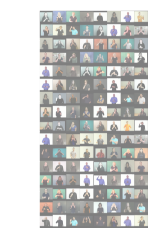

Predictions for batch 1 
['doctor', 'now', 'letter', 'man', 'clothes', 'before', 'later', 'go', 'paint', 'purple', 'computer', 'purple', 'hot', 'right', 'white', 'language', 'hearing', 'basketball', 'year', 'give', 'apple', 'mother', 'candy', 'right', 'pink', 'study', 'hearing', 'pull', 'basketball', 'pizza', 'deaf', 'cool', 'white', 'later', 'woman', 'but', 'time', 'year', 'study', 'yes', 'give', 'letter', 'hot', 'wrong', 'thursday', 'short', 'drink', 'work', 'birthday', 'blue', 'cool', 'apple', 'son', 'cook', 'language', 'deaf', 'book', 'thanksgiving', 'birthday', 'tall', 'cool', 'eat', 'eat', 'no', 'year', 'chair', 'woman', 'last', 'thanksgiving', 'meet', 'jacket', 'go', 'need', 'blue', 'last', 'walk', 'can', 'year', 'decide', 'medicine', 'tall', 'corn', 'hearing', 'what', 'play', 'how', 'hearing', 'no', 'who', 'woman', 'orange', 'secretary', 'dog', 'school', 'orange', 'deaf', 'decide', 'dog', 'tall', 'bowling', 'tall', 'how', 'book', 'deaf', 'eat', 'secretary', 'who', 'family', 'ho

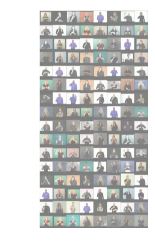

Predictions for batch 1 
['chair', 'eat', 'tell', 'how', 'book', 'graduate', 'cow', 'full', 'paper', 'secretary', 'how', 'help', 'play', 'walk', 'language', 'deaf', 'short', 'clothes', 'cook', 'mother', 'thin', 'table', 'change', 'medicine', 'what', 'thursday', 'cow', 'same', 'walk', 'brown', 'same', 'hearing', 'pull', 'enjoy', 'who', 'table', 'mother', 'dark', 'son', 'full', 'many', 'many', 'drink', 'pink', 'can', 'enjoy', 'dance', 'but', 'hat', 'no', 'paint', 'pink', 'study', 'drink', 'tall', 'pull', 'time', 'son', 'hearing', 'language', 'purple', 'like', 'white', 'later', 'need', 'orange', 'dog', 'eat', 'walk', 'eat', 'finish', 'jacket', 'cousin', 'purple', 'accident', 'paper', 'hat', 'book', 'doctor', 'bird', 'orange', 'tall', 'help', 'many', 'black', 'hot', 'before', 'corn', 'finish', 'school', 'study', 'later', 'cool', 'forget', 'doctor', 'book', 'bird', 'apple', 'no', 'tell', 'same', 'dog', 'who', 'mother', 'birthday', 'fine', 'hat', 'paper', 'go', 'decide', 'corn', 'give', 'thu

In [27]:
print("Checking accuracy on Training Set and normal model")
check_accuracy(train_loader, model)

print("Checking accuracy on Training Set and quantized model")
check_accuracy(train_loader, quantized_model)

Checking accuracy on Test Set and normal model
Images for 1


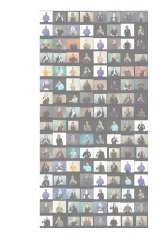

Predictions for batch 1 
['time', 'drink', 'chair', 'book', 'want', 'book', 'give', 'eat', 'birthday', 'no', 'help', 'how', 'paint', 'like', 'go', 'accident', 'pull', 'finish', 'cousin', 'many', 'son', 'hot', 'fish', 'before', 'later', 'family', 'corn', 'study', 'bed', 'go', 'paint', 'play', 'table', 'who', 'can', 'cow', 'help', 'fish', 'forget', 'enjoy', 'hat', 'corn', 'work', 'no', 'year', 'purple', 'who', 'full', 'deaf', 'book', 'computer', 'give', 'full', 'forget', 'candy', 'dance', 'bird', 'color', 'hot', 'black', 'tell', 'white', 'wrong', 'now', 'apple', 'cool', 'chair', 'before', 'thin', 'year', 'corn', 'secretary', 'year', 'before', 'woman', 'fine', 'many', 'family', 'now', 'all', 'who', 'thin', 'bird', 'last', 'thursday', 'finish', 'last', 'thursday', 'paper', 'cheat', 'jacket', 'later', 'candy', 'white', 'bowling', 'enjoy', 'right', 'full', 'paint', 'thin', 'cook', 'language', 'language', 'color', 'want', 'pink', 'shirt', 'want', 'thin', 'woman', 'cook', 'jacket', 'time', 'pu

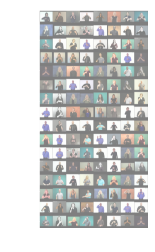

Predictions for batch 1 
['cook', 'orange', 'chair', 'jacket', 'clothes', 'like', 'time', 'secretary', 'corn', 'paint', 'play', 'study', 'computer', 'give', 'black', 'corn', 'walk', 'woman', 'pink', 'what', 'language', 'family', 'shirt', 'computer', 'wrong', 'book', 'book', 'color', 'short', 'before', 'help', 'family', 'meet', 'eat', 'wrong', 'thin', 'woman', 'apple', 'who', 'bird', 'basketball', 'man', 'thin', 'medicine', 'thin', 'deaf', 'birthday', 'dog', 'pizza', 'same', 'mother', 'clothes', 'who', 'doctor', 'later', 'many', 'what', 'drink', 'apple', 'hat', 'pink', 'black', 'bed', 'fine', 'tell', 'mother', 'drink', 'bowling', 'computer', 'fish', 'cheat', 'forget', 'hot', 'cheat', 'how', 'year', 'many', 'cousin', 'short', 'mother', 'wrong', 'accident', 'book', 'man', 'computer', 'drink', 'purple', 'letter', 'cook', 'secretary', 'want', 'computer', 'language', 'study', 'cook', 'go', 'purple', 'decide', 'shirt', 'thanksgiving', 'hot', 'pull', 'blue', 'full', 'fish', 'candy', 'finish', 

In [28]:
print("Checking accuracy on Test Set and normal model")
check_accuracy(test_loader, model)

print("Checking accuracy on Test Set and quantized model")
check_accuracy(test_loader, quantized_model)

### Check train and test on same class.

In [29]:
def predict_class(loader, model, debug_label):

    for images, targets in loader:

        scores = model(images)
        _, predictions = scores.max(1)

        for i, (image, target) in enumerate(zip(images, targets)):
            label = classes[target]
            if label != debug_label:
                continue

            # Predict label for image.
            prediction_id = predictions[i]
            prediction = classes[prediction_id]

            # Show image.
            imshow(image.cpu())

            print(f"Prediction: {prediction}. Ground truth: {label}")

            return


In [30]:
debug_label = "apple"


Prediction for apple and train set


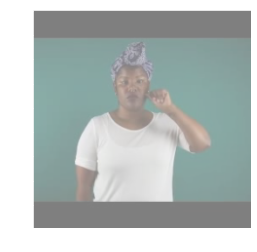

Prediction: apple. Ground truth: apple


In [31]:
print(f"Prediction for {debug_label} and train set")
predict_class(train_loader, model, debug_label)


Prediction for apple and test set


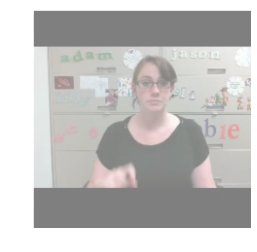

Prediction: year. Ground truth: apple


In [32]:
print(f"Prediction for {debug_label} and test set")
predict_class(test_loader, model, debug_label)


### Inference with webcam

In [33]:
def Webcam_720p(cap):
    cap.set(3, 1280)
    cap.set(4, 720)


def argmax(scores):
    percentage = F.softmax(scores, dim=1)[0] * 100
    _, indices = torch.sort(scores, descending=True)
    first_five = [(classes[idx], percentage[idx].item()) for idx in indices[0][:5]]

    # _, prediction = scores.max(1)
    # result = classes[prediction]

    # score = F.softmax(scores, dim=1)[0] * 100
    # score = score[prediction]

    return first_five


def preprocess(image):
    image = Image.fromarray(image)
    # Webcam frames are numpy array format
    # Therefore transform back to PIL image
    image = transform(image)
    image = image.float()
    image = image.to(device)
    image = torch.unsqueeze(image, 0)
    return image


In [34]:
model.to(device)

cap = cv2.VideoCapture(0)  # Set the webcam
Webcam_720p(cap)

fps = 0
show_score = 0
first_five = []
sequence = 0
while True:
    ret, frame = cap.read()  # Capture each frame

    if fps == 15:
        image = frame#[100:400, 150:550]
        image_data = preprocess(image)

        scores = model(image_data)
        first_five = argmax(scores)

        fps = 0

    fps += 1

    y = 150
    for label, score in first_five:
        y += 50
        cv2.putText(
            frame,
            f"{label} - {score:.2f}",
            (900, y),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 0, 255),
            2,
        )
        
    # cv2.rectangle(frame, (400, 150), (900, 550), (250, 0, 0), 2)
    cv2.imshow("ASL SIGN DETECTER", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyWindow("ASL SIGN DETECTER")


### Test image from file

In [35]:
image_path = "./sdfdf.jpg"

In [36]:
image = Image.open(image_path).convert("RGB")
image_transformed = transform(image)
image_tensor = torch.unsqueeze(image_transformed, 0)
image_gpu = image_tensor.to(device)
output = model(image_gpu)

output
percentage = F.softmax(output, dim=1)[0] * 100

_, indices = torch.sort(output, descending=True)
[(classes[idx], percentage[idx].item()) for idx in indices[0][:5]]